<a href="https://colab.research.google.com/github/MarceloCapeletti/creditcard_fraud_detection/blob/main/projeto_credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de descrição e detecção de fraudes em banco de dados de transações em cartão de crédito

O banco é disponibilizado pela plataforma Kaggle:
https://www.kaggle.com/mlg-ulb/creditcardfraud

Para contexto, o banco apresenta transações de cartão de credito de dois dias de semtebro de 2013 na Europa, em que ocorreram 284807 transações com 492 fraudes, sendo assim considerado um banco de dados desbalanceado.

O objetivo deste notebook é realizar uma análise descritiva das entradas disponibilizadas no banco, após aplicação e otimização dos hiperparâmetros da  Rede Neural Artificial. Dado a caracteristica do banco desbalanceado, os métodos serão empregados como detectores de outliers com uma aprendizagem supervisionada.

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# INSTALAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

#!pip install pandas==1.3.4
#!pip install numpy==1.21.0
#!pip install matplotlib==3.4.3
!pip install tensorflow==2.5.0
!pip install keras_tuner
!pip install -U imbalanced-learn
!pip install keras==2.6.0

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# IMPORTAR BIBLIOTECAS
#----------------------------------------------------------------------------------------------------------------

# BIBLIOTECAS DE MANIPULAÇÃO DE DADOS

import pandas as pd
import numpy as np


# BIBLIOTECAS PARA PLOTAR DADOS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# BIBLIOTECAS ALGORITMOS DE  APRENDIZADO DE MÁQUINA E TUNING


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
import keras_tuner as kt

from keras_tuner import Objective
from keras_tuner.tuners import BayesianOptimization 
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from imblearn.under_sampling import RandomUnderSampler

# BIBLIOTECA TIME

import time

### CONFIGURANDO PANDAS

In [ ]:
#----------------------------------------------------------------------------------------------------------------
# CONFIGURANDO E ESTILIZANDO PANDAS
#----------------------------------------------------------------------------------------------------------------

pd.set_option('display.max_rows',600) 
pd.get_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('precision',4)
#pd.reset_option('all')



def positiveandnegative_colors(value):

  if value > 0: 
    color = 'black'
  else: 
    color = 'red'

  return 'color: %s' % color

stylepattern = [
  {'selector': 'th',
    'props': [('background', 'white'), 
              ('color', 'black'),
              ('font-family', 'arial'),
              ('text-align', 'center')]},

  {'selector': 'tr:nth-of-type(odd)',
    'props': [('background', '#DCDCDC')]}, 
 
  {'selector': 'tr:nth-of-type(even)',
    'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
    'props': [('background-color', '#0000FF')]}
          ]

def Custom_Ax(ax, ylabel_name='', ylabel_size=16, xlabel_name='', xlabel_size=16):

    ax.set_ylabel(ylabel_name, fontdict={'fontsize': ylabel_size})
    ax.set_xlabel(xlabel_name, fontdict={'fontsize': xlabel_size})
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', axis="x", color="black", alpha=1, linewidth=.5, linestyle="-")
    ax.grid(visible=True, which='major', axis="y", color="black", alpha=1, linewidth=.5, linestyle="-")

    return ax

In [ ]:
tf.__version__

'2.5.0'

ESTILIZANDO E CONFIGURANDO PLOTTAGEM E IMPRESSÕES DOS DADOS 


## Carregar dataframe de transações de crédito

In [ ]:
df_credit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df_credit.columns.name = 'Features'
df_credit.index.name = 'Index'
df_credit.head(20).style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0
5,2.0000,-0.4260,0.9605,1.1411,-0.1683,0.4210,-0.0297,0.4762,0.2603,-0.5687,-0.3714,1.3413,0.3599,-0.3581,-0.1371,0.5176,0.4017,-0.0581,0.0687,-0.0332,0.0850,-0.2083,-0.5598,-0.0264,-0.3714,-0.2328,0.1059,0.2538,0.0811,3.6700,0
6,4.0000,1.2297,0.1410,0.0454,1.2026,0.1919,0.2727,-0.0052,0.0812,0.4650,-0.0993,-1.4169,-0.1538,-0.7511,0.1674,0.0501,-0.4436,0.0028,-0.6120,-0.0456,-0.2196,-0.1677,-0.2707,-0.1541,-0.7801,0.7501,-0.2572,0.0345,0.0052,4.9900,0
7,7.0000,-0.6443,1.4180,1.0744,-0.4922,0.9489,0.4281,1.1206,-3.8079,0.6154,1.2494,-0.6195,0.2915,1.7580,-1.3239,0.6861,-0.0761,-1.2221,-0.3582,0.3245,-0.1567,1.9435,-1.0155,0.0575,-0.6497,-0.4153,-0.0516,-1.2069,-1.0853,40.8000,0
8,7.0000,-0.8943,0.2862,-0.1132,-0.2715,2.6696,3.7218,0.3701,0.8511,-0.3920,-0.4104,-0.7051,-0.1105,-0.2863,0.0744,-0.3288,-0.2101,-0.4998,0.1188,0.5703,0.0527,-0.0734,-0.2681,-0.2042,1.0116,0.3732,-0.3842,0.0117,0.1424,93.2000,0


Infelizmente devido a confiabilidade as features de entradas foram alteradas com PCA, que é definido como uma transformação linear ortogonal que transforma os dados em um novo sistema de coordenadas.

As features com valores reais são 'Time' que representa o valor em segundos entre transações, e 'Amount' representando o valor monetário de cada transação.

Os gráficos a seguir demonstra o Tempo x Valor das transações , demarcado operações fraudulentas

<AxesSubplot:xlabel='Time', ylabel='Amount'>

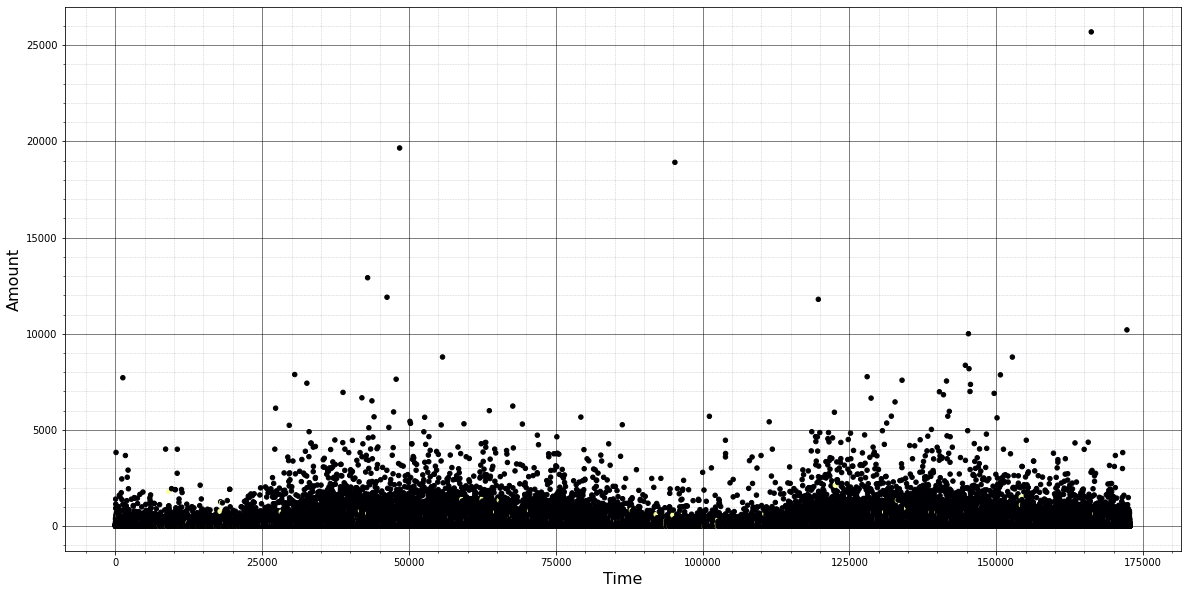

In [ ]:
fig, ax = plt.subplots()

ax = Custom_Ax(ax)

df_credit[['Time','Amount']].plot(kind='scatter',x='Time', y = 'Amount',figsize=(20,10), c=df_credit['Class'],colormap='inferno',colorbar=False, grid=True, ax=ax)

Zoom in, com objetivo de melhorar visualização

<AxesSubplot:xlabel='Time', ylabel='Amount'>

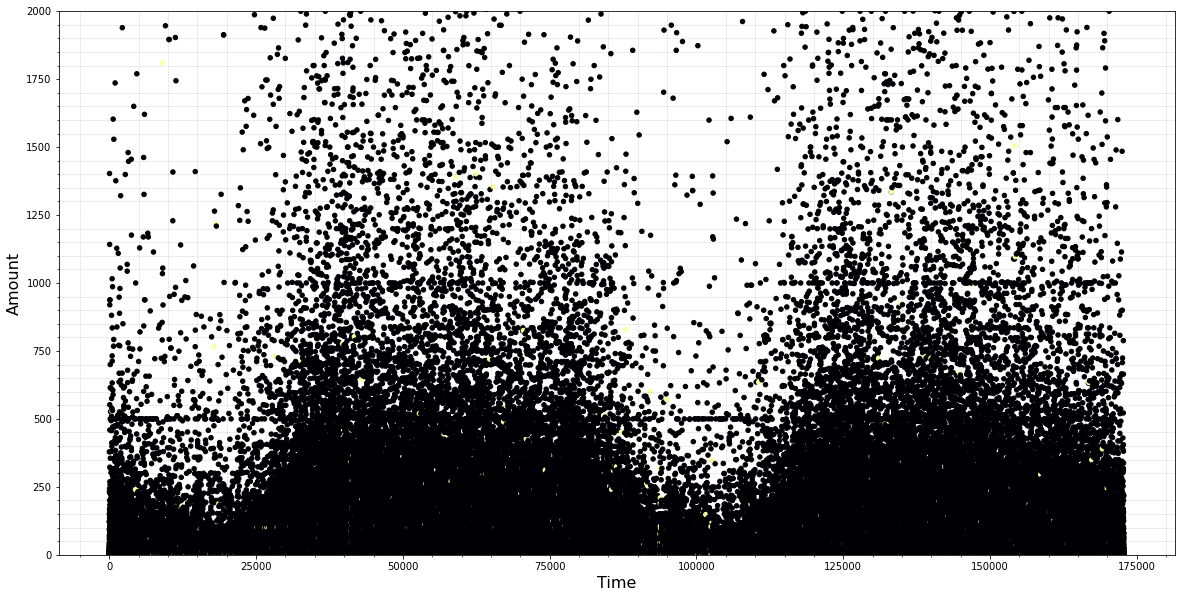

In [ ]:
fig, ax = plt.subplots()

ax = Custom_Ax(ax)

df_credit[['Time','Amount']].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000),c=df_credit['Class'],colormap='inferno',colorbar=False,ax=ax)

### Histogramas / Distribuição de frequências V1, V2 ... V28
Para todas as variáveis alteradas, é realizado impressão de histogramas com objetivo de visualizar como elas estão distribuidas, filtrando como operações legítimas e fraudulentos

## **Histogramas legítimas**


---



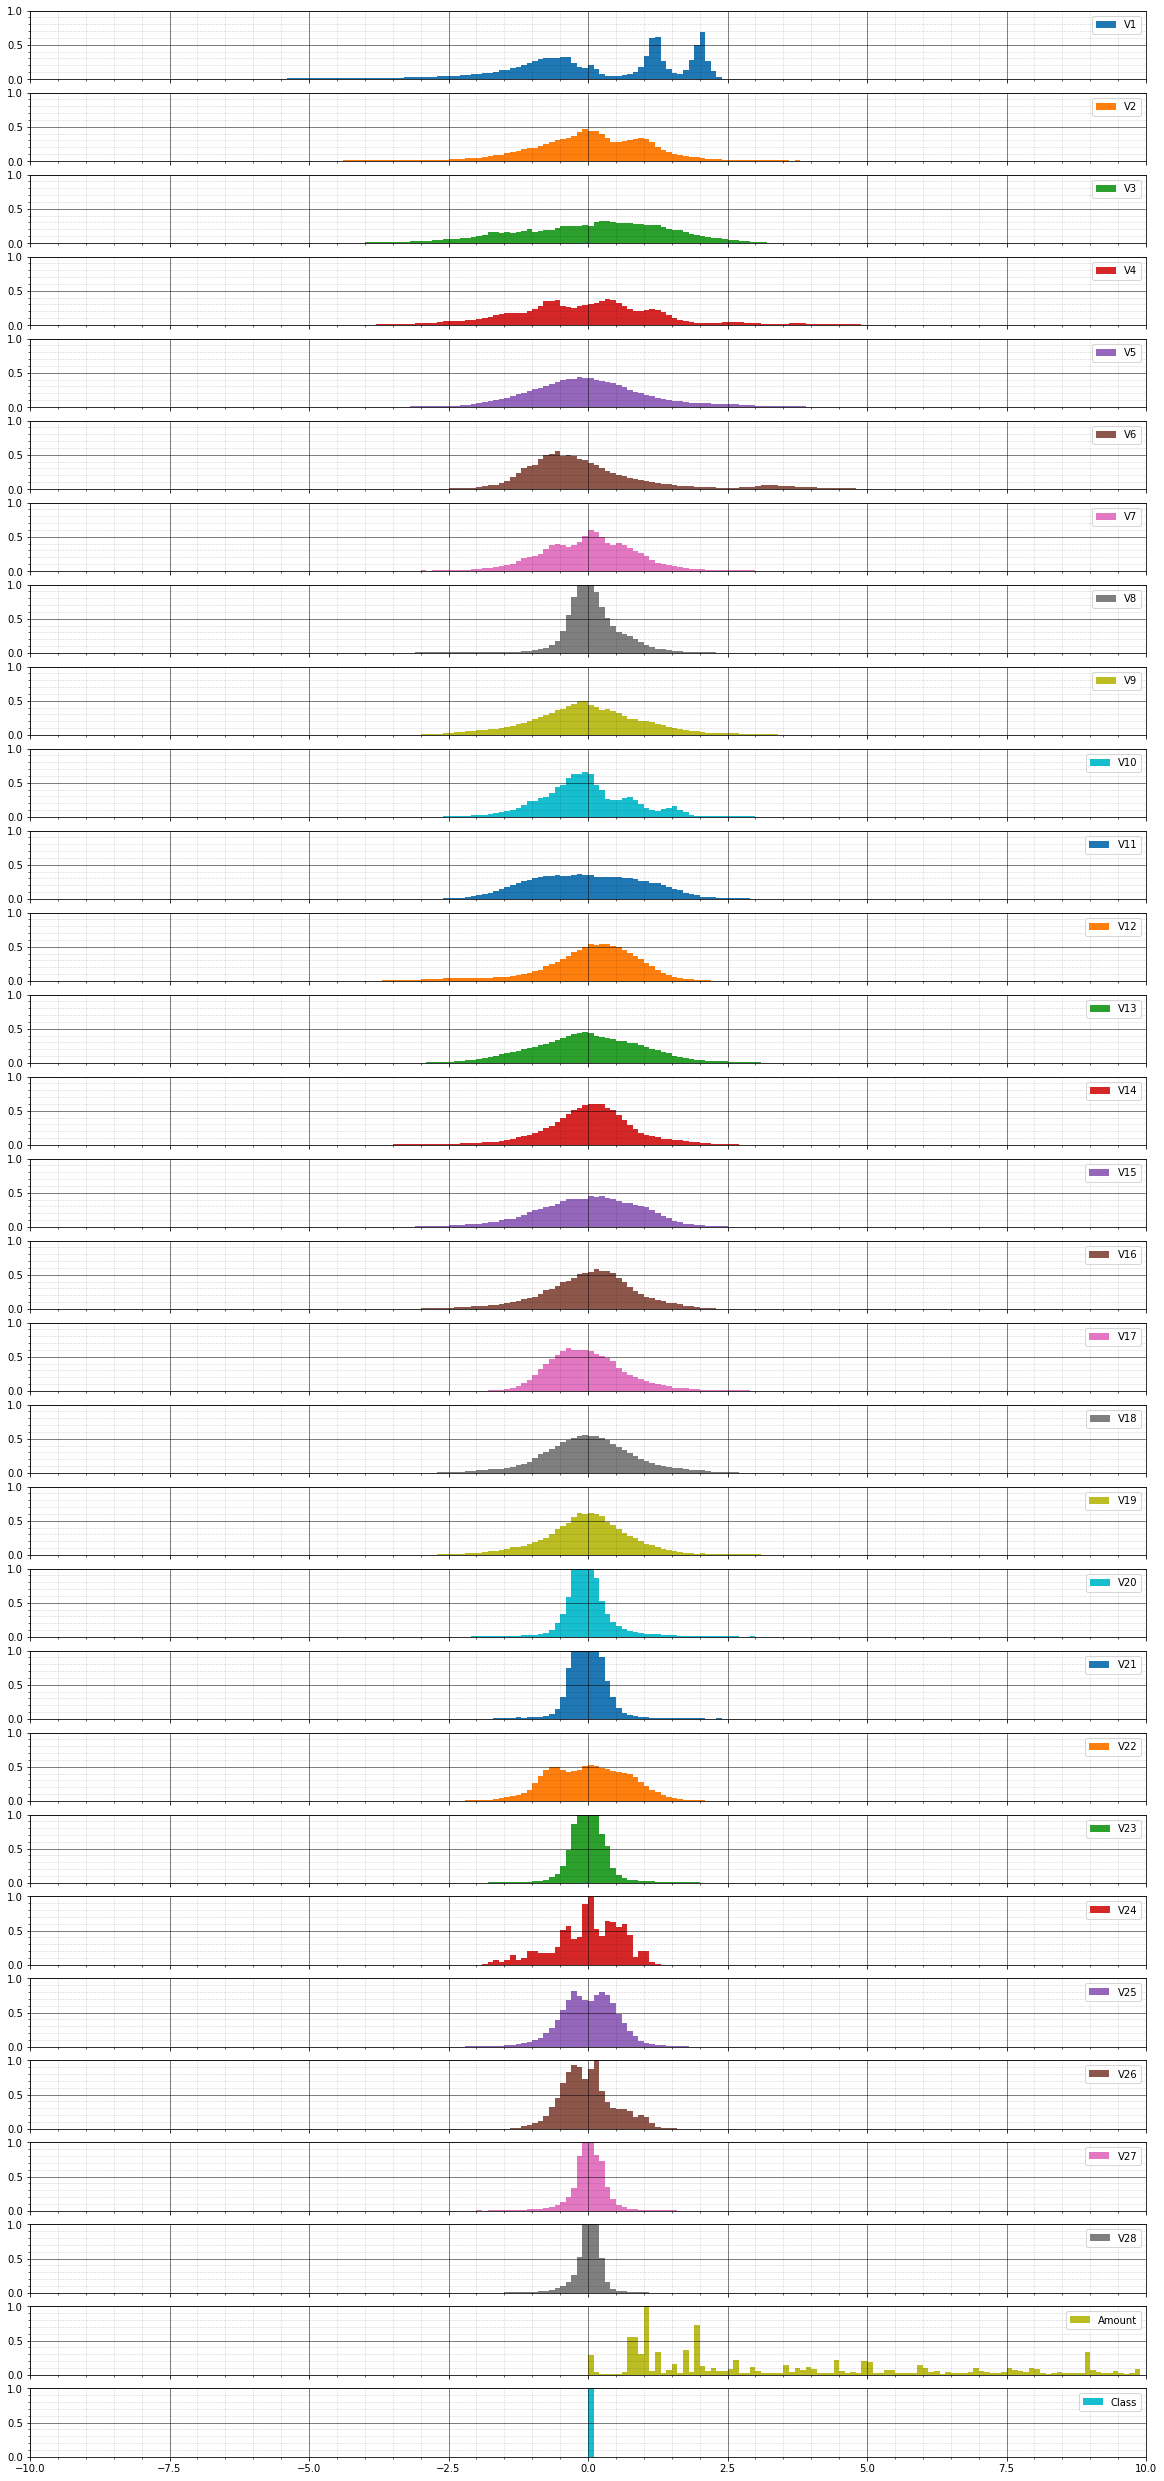

In [ ]:
ax = df_credit.iloc[:,1:31].query('Class == 0').plot(kind='hist', figsize=(20,45), xlim=(-10,10), ylim=(0,1),bins=np.arange(-10, 10, .1),subplots=True,density=True)

for subplot in ax:
  
  subplot = Custom_Ax(subplot)



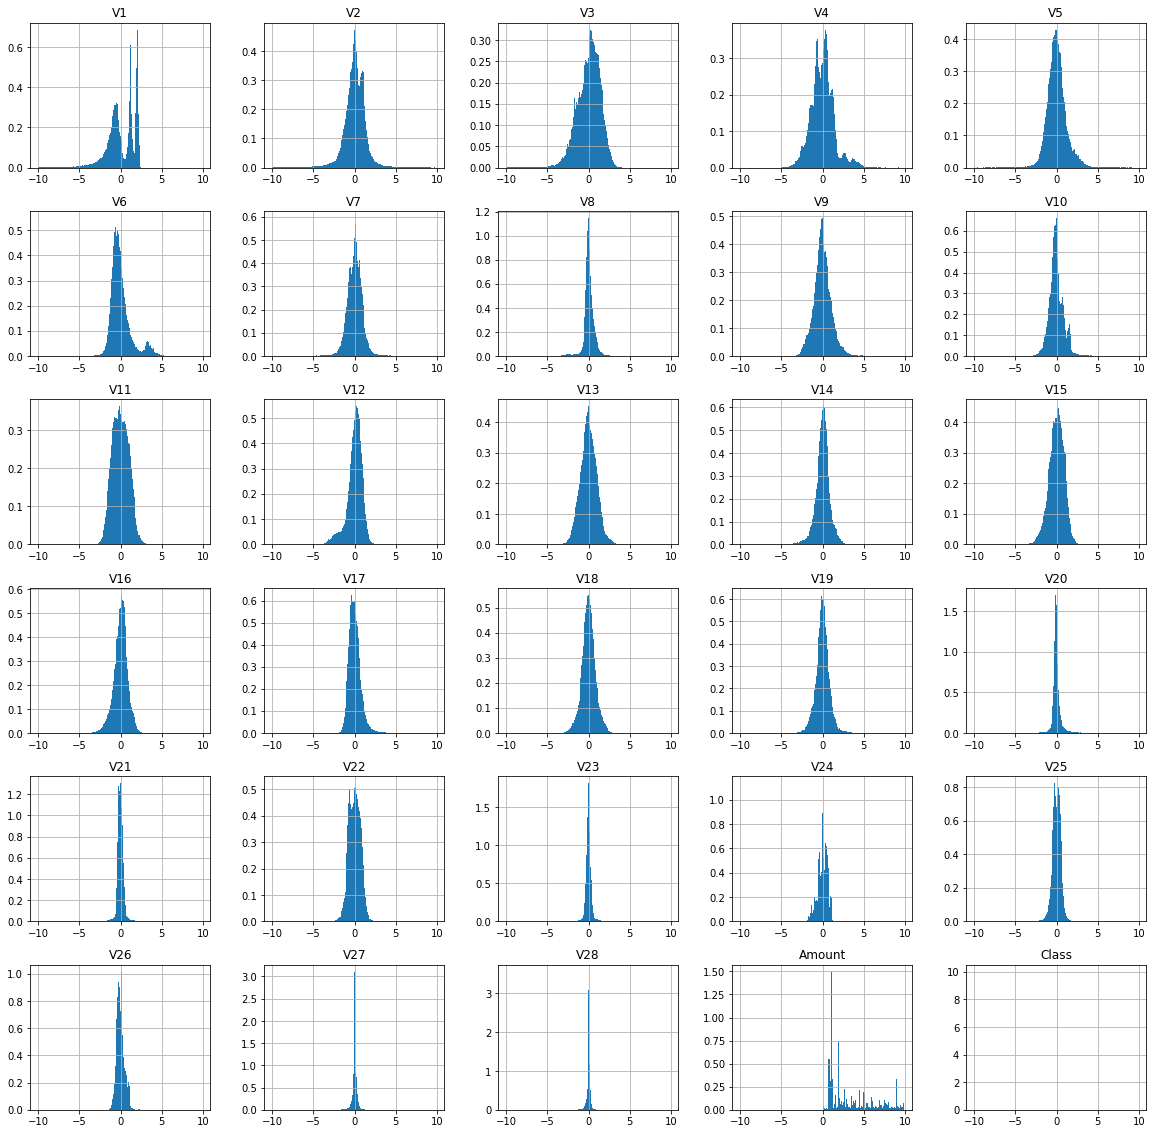

In [ ]:
ax = df_credit.iloc[:,1:31].query('Class == 0').hist(figsize=(20,20),bins=np.arange(-10, 10, .1),density=True)

## **Histogramas Fraudulentos**

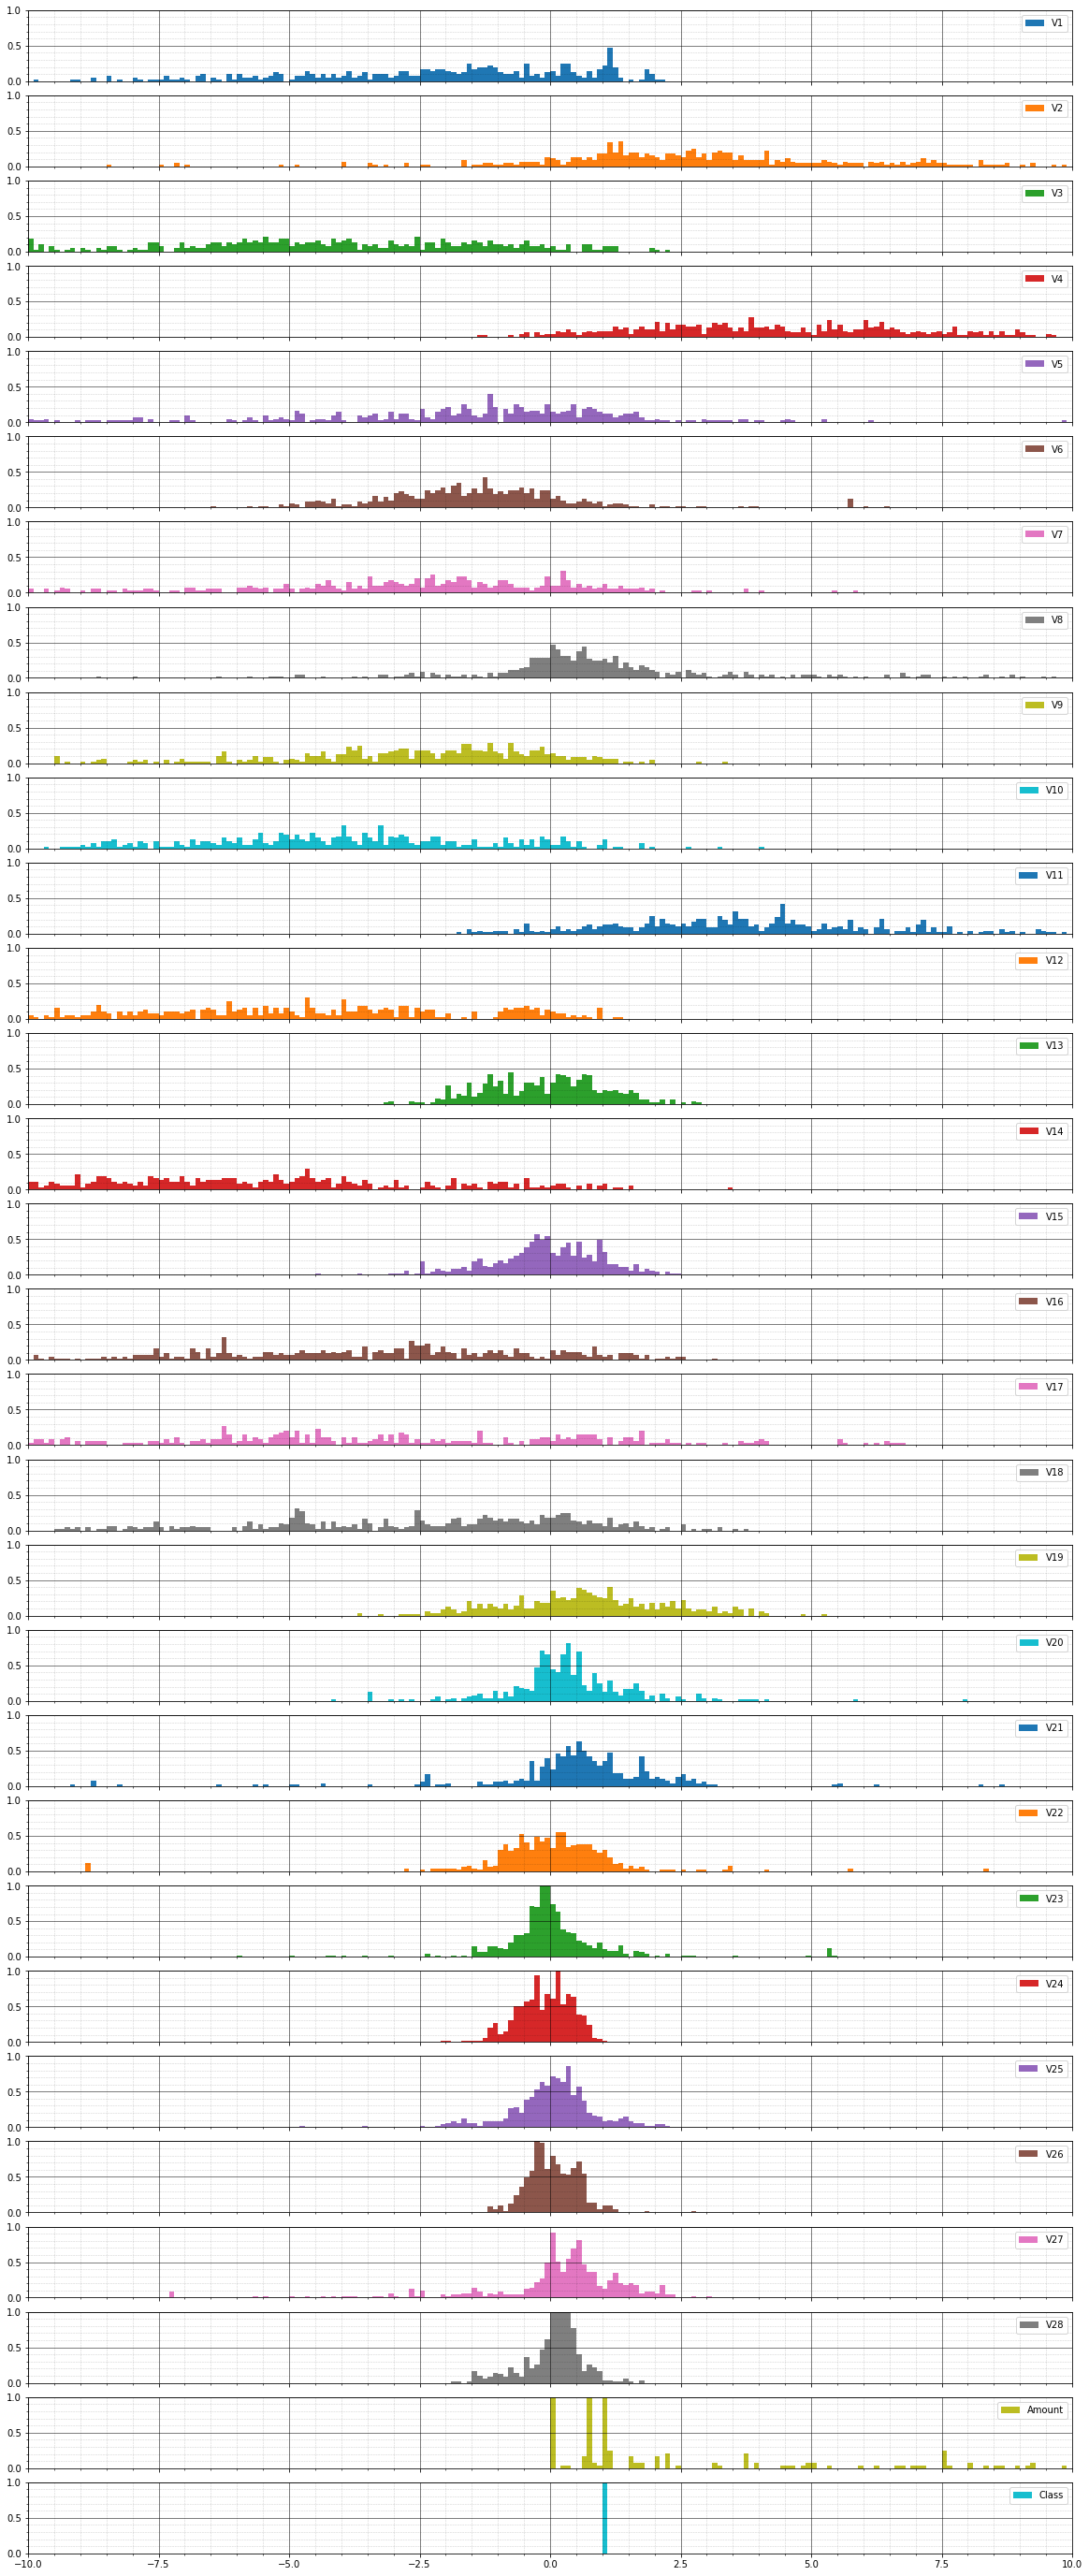

In [ ]:
ax = df_credit.iloc[:,1:31].query('Class == 1').plot(kind='hist', figsize=(20,50),xlim=(-10,10),ylim=(0,1),bins=np.arange(-10, 10, .1),subplots=True,density=True)

for subplot in ax:
  
  subplot = Custom_Ax(subplot)


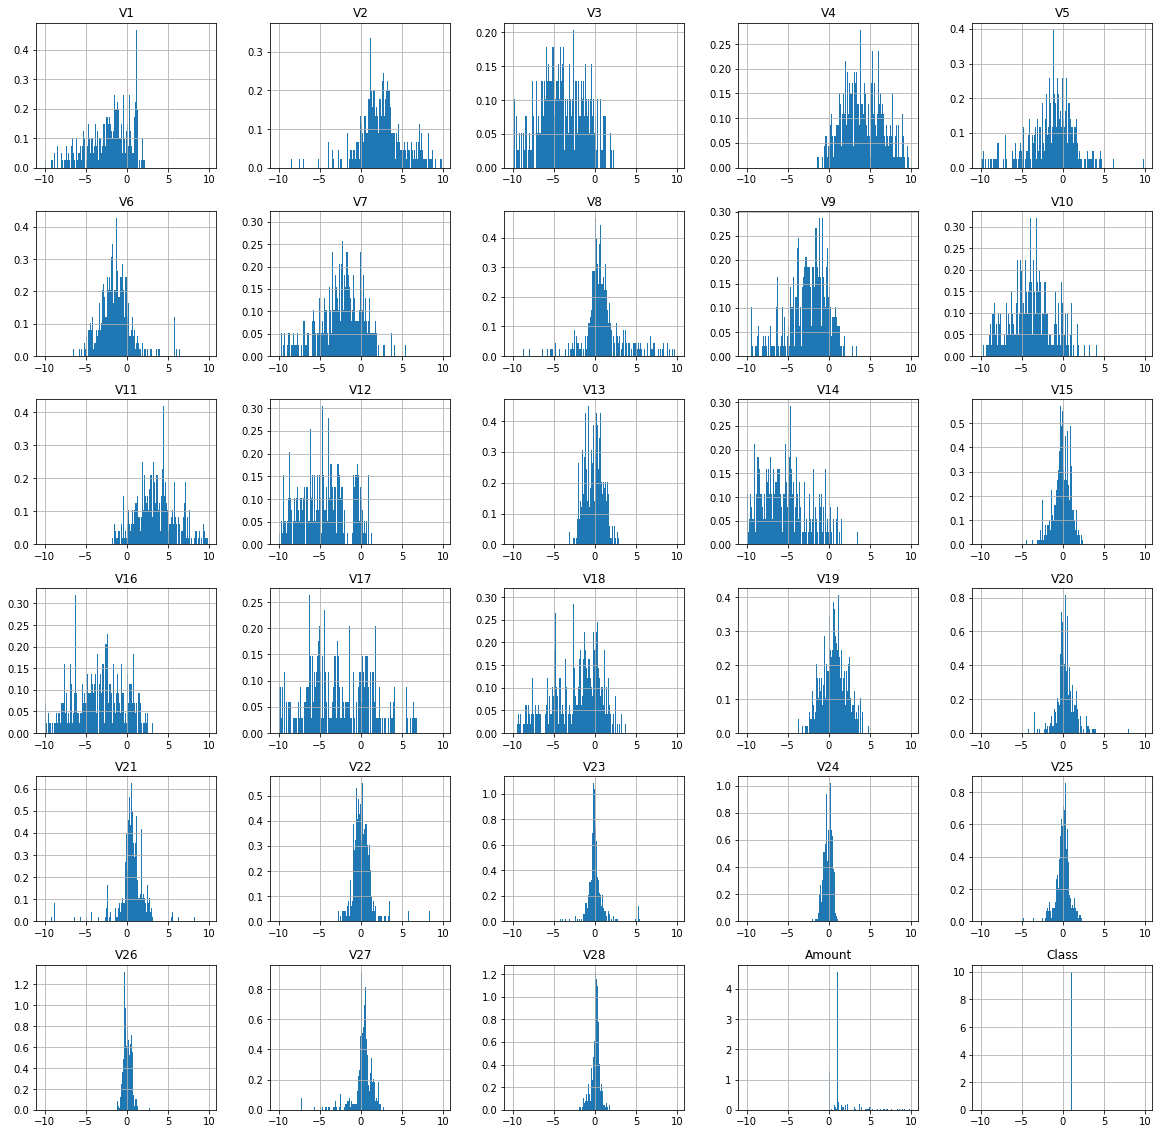

In [ ]:
ax = df_credit.iloc[:,1:31].query('Class == 1').hist(figsize=(20,20),bins=np.arange(-10, 10, .1),density=True)

### Filtrando as operações fraudulentas e legítimas


In [ ]:
df_credit.loc[(df_credit["Class"] == 0)].describe()\
              .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors) # Descrição do Dataframe filtrando operações fraudulentas

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000,284315.0000
mean,94838.2023,0.0083,-0.0063,0.0122,-0.0079,0.0055,0.0024,0.0096,-0.0010,0.0045,0.0098,-0.0066,0.0108,0.0002,0.0121,0.0002,0.0072,0.0115,0.0039,-0.0012,-0.0006,-0.0012,-0.0000,0.0001,0.0002,-0.0001,-0.0001,-0.0003,-0.0001,88.2910,0.0000
std,47484.0158,1.9298,1.6361,1.4594,1.3993,1.3570,1.3299,1.1788,1.1613,1.0894,1.0442,1.0031,0.9459,0.9951,0.8970,0.9151,0.8448,0.7495,0.8249,0.8117,0.7694,0.7167,0.7237,0.6215,0.6058,0.5207,0.4822,0.3998,0.3296,250.1051,0.0000
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-31.7649,-73.2167,-6.2907,-14.7411,-4.7975,-15.1450,-5.7919,-18.3921,-4.3913,-10.1156,-17.0984,-5.3667,-7.2135,-54.4977,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54230.0000,-0.9175,-0.5995,-0.8845,-0.8501,-0.6894,-0.7668,-0.5514,-0.2086,-0.6404,-0.5329,-0.7634,-0.4021,-0.6481,-0.4225,-0.5828,-0.4655,-0.4826,-0.4974,-0.4564,-0.2118,-0.2285,-0.5424,-0.1617,-0.3544,-0.3171,-0.3271,-0.0709,-0.0529,5.6500,0.0000
50%,84711.0000,0.0200,0.0641,0.1822,-0.0224,-0.0535,-0.2731,0.0411,0.0220,-0.0500,-0.0919,-0.0349,0.1417,-0.0135,0.0519,0.0483,0.0674,-0.0648,-0.0028,0.0031,-0.0626,-0.0298,0.0067,-0.0111,0.0411,0.0164,-0.0522,0.0012,0.0112,22.0000,0.0000
75%,139333.0000,1.3162,0.8004,1.0284,0.7376,0.6122,0.3996,0.5710,0.3262,0.5982,0.4551,0.7364,0.6192,0.6625,0.4941,0.6488,0.5237,0.3999,0.5011,0.4575,0.1324,0.1856,0.5284,0.1475,0.4399,0.3506,0.2407,0.0906,0.0780,77.0500,0.0000
max,172792.0000,2.4549,18.9025,9.3826,16.8753,34.8017,73.3016,120.5895,18.7093,15.5950,23.7451,10.0022,7.8484,7.1269,10.5268,8.8777,17.3151,9.2535,5.0411,5.5920,39.4209,22.6149,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,0.0000


In [ ]:
df_credit.loc[(df_credit.Class == 1)].describe()\
                .style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000,492.0000
mean,80746.8069,-4.7719,3.6238,-7.0333,4.5420,-3.1512,-1.3977,-5.5687,0.5706,-2.5811,-5.6769,3.8002,-6.2594,-0.1093,-6.9717,-0.0929,-4.1399,-6.6658,-2.2463,0.6807,0.3723,0.7136,0.0140,-0.0403,-0.1051,0.0414,0.0516,0.1706,0.0757,122.2113,1.0000
std,47835.3651,6.7837,4.2912,7.1109,2.8733,5.3725,1.8581,7.2068,6.7978,2.5009,4.8973,2.6786,4.6545,1.1045,4.2789,1.0499,3.8650,6.9706,2.8994,1.5399,1.3466,3.8693,1.4946,1.5796,0.5156,0.7972,0.4717,1.3768,0.5473,256.6833,0.0000
min,406.0000,-30.5524,-8.4022,-31.1037,-1.3133,-22.1055,-6.4063,-43.5572,-41.0443,-13.4341,-24.5883,-1.7022,-18.6837,-3.1278,-19.2143,-4.4989,-14.1299,-25.1628,-9.4987,-3.6819,-4.1282,-22.7976,-8.8870,-19.2543,-2.0280,-4.7816,-1.1527,-7.2635,-1.8693,0.0000,1.0000
25%,41241.5000,-6.0361,1.1882,-8.6435,2.3730,-4.7928,-2.5015,-7.9653,-0.1953,-3.8724,-7.7567,1.9734,-8.6882,-0.9791,-9.6927,-0.6435,-6.5629,-11.9451,-4.6646,-0.2994,-0.1718,0.0418,-0.5338,-0.3422,-0.4368,-0.3143,-0.2594,-0.0200,-0.1089,1.0000,1.0000
50%,75568.5000,-2.3425,2.7179,-5.0753,4.1771,-1.5230,-1.4246,-3.0344,0.6215,-2.2088,-4.5788,3.5862,-5.5025,-0.0656,-6.7297,-0.0572,-3.5498,-5.3029,-1.6643,0.6468,0.2847,0.5921,0.0484,-0.0731,-0.0608,0.0884,0.0043,0.3949,0.1463,9.2500,1.0000
75%,128483.0000,-0.4192,4.9713,-2.2762,6.3487,0.2146,-0.4132,-0.9460,1.7649,-0.7879,-2.6142,5.3071,-2.9741,0.6730,-4.2828,0.6092,-1.2260,-1.3419,0.0918,1.6493,0.8224,1.2446,0.6175,0.3084,0.2853,0.4565,0.3967,0.8260,0.3812,105.8900,1.0000
max,170348.0000,2.1324,22.0577,2.2502,12.1147,11.0951,6.4741,5.8025,20.0072,3.3535,4.0314,12.0189,1.3759,2.8154,3.4424,2.4714,3.1397,6.7394,3.7903,5.2283,11.0590,27.2028,8.3620,5.4662,1.0914,2.2082,2.7453,3.0524,1.7794,2125.8700,1.0000


### Visualizando Time x Amount de operações fraudulentas e legítimas

## **Fraudulentas**

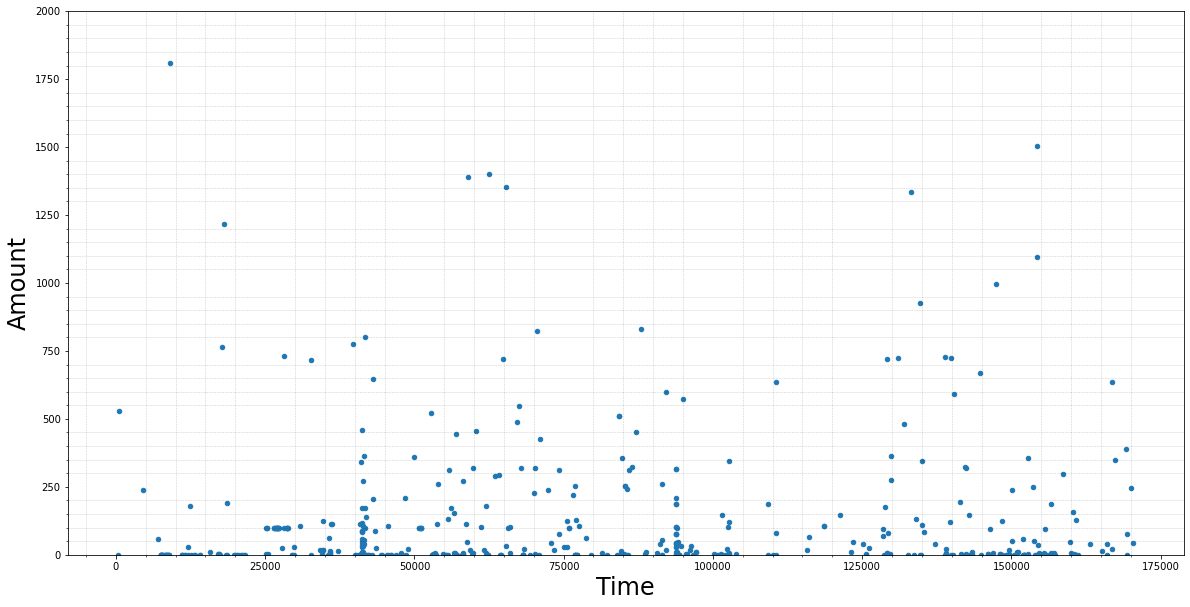

In [ ]:
fig, ax = plt.subplots()

ax = Custom_Ax(ax, ylabel_size=24, xlabel_size=24)

df_credit.loc[df_credit.Class==1].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000),ax=ax)
plt.show()

## **Legítimas**

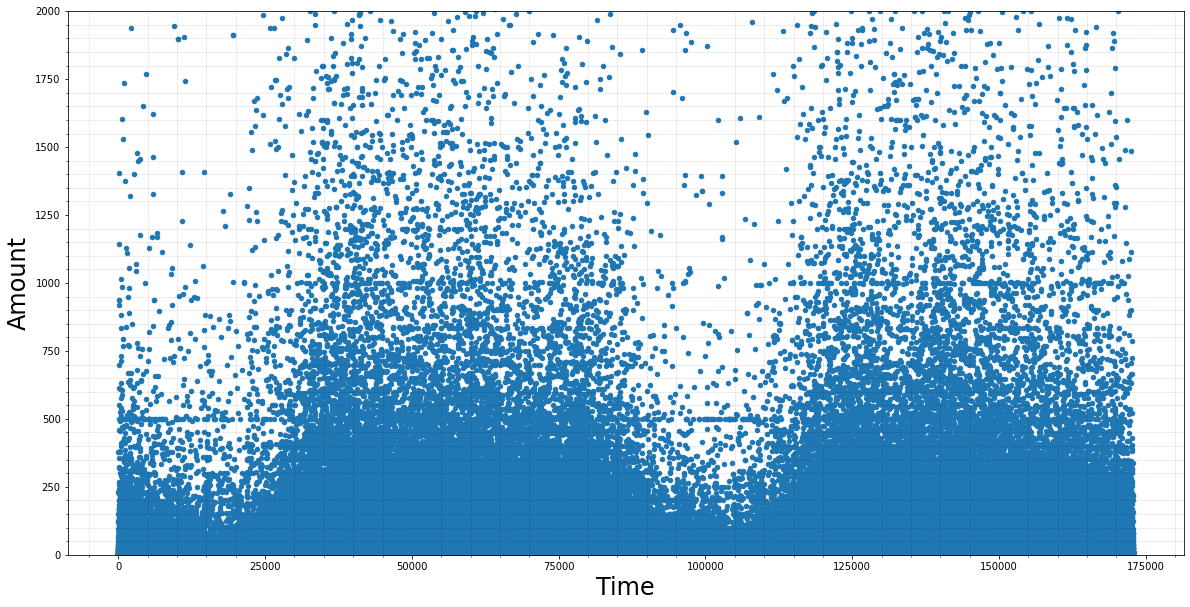

In [ ]:
fig, ax = plt.subplots()

ax = Custom_Ax(ax, ylabel_size=24, xlabel_size=24)

df_credit.loc[df_credit.Class==0].plot(kind='scatter', x='Time', y='Amount', figsize=(20,10), ylim=(0,2000),ax=ax)
plt.show()

### **BoxPlot das váriaveis V1 ~ V28**

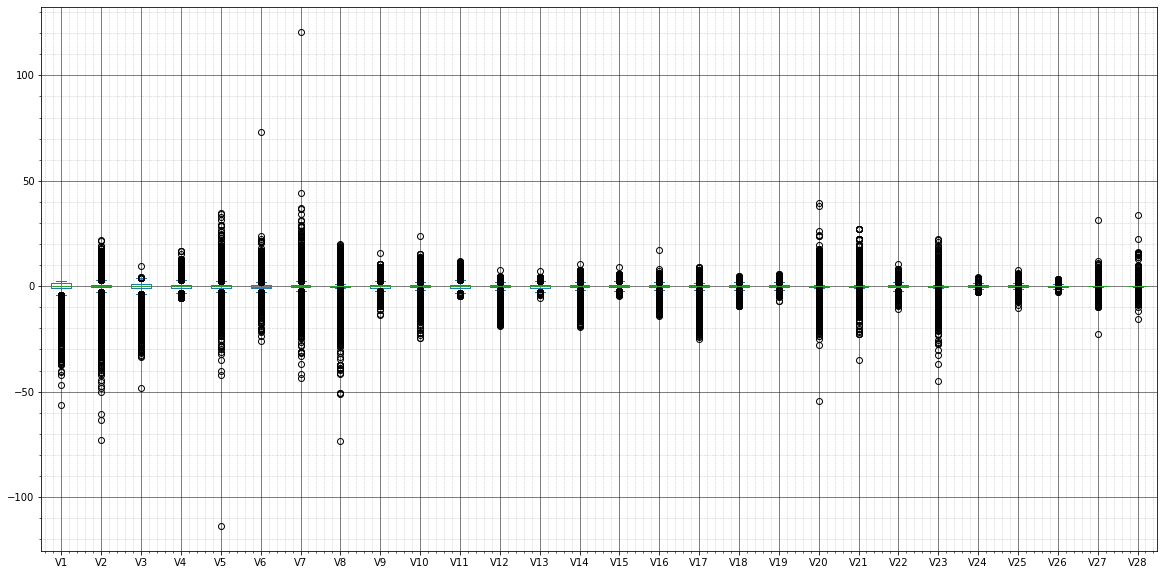

In [ ]:
ax = df_credit.iloc[:,1:29].plot(kind='box', figsize=(20,10))

ax.grid(color='black', linestyle='-', linewidth=1,alpha=.5) 
ax.grid(which='minor', axis="x", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.grid(which='minor', axis="y", color="black", alpha=.2, linewidth=.5, linestyle="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

In [ ]:
df_credit.corr().style.set_table_styles(stylepattern).background_gradient(cmap='Purples').applymap(positiveandnegative_colors)

Features,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Time,1.0000,0.1174,-0.0106,-0.4196,-0.1053,0.1731,-0.0630,0.0847,-0.0369,-0.0087,0.0306,-0.2477,0.1243,-0.0659,-0.0988,-0.1835,0.0119,-0.0733,0.0904,0.0290,-0.0509,0.0447,0.1441,0.0511,-0.0162,-0.2331,-0.0414,-0.0051,-0.0094,-0.0106,-0.0123
V1,0.1174,1.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2277,-0.1013
V2,-0.0106,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.5314,0.0913
V3,-0.4196,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.2109,-0.1930
V4,-0.1053,-0.0000,-0.0000,0.0000,1.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0987,0.1334
V5,0.1731,0.0000,0.0000,-0.0000,-0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.3864,-0.0950
V6,-0.0630,-0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2160,-0.0436
V7,0.0847,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.3973,-0.1873
V8,-0.0369,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.1031,0.0199


### APRENDIZADO DE MÁQUINA E TUNNING

In [ ]:
df_credit.drop(columns='Time',inplace=True)

In [ ]:
df_credit.head(20).style.set_table_styles(stylepattern).applymap(positiveandnegative_colors)

Features,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0
5,-0.4260,0.9605,1.1411,-0.1683,0.4210,-0.0297,0.4762,0.2603,-0.5687,-0.3714,1.3413,0.3599,-0.3581,-0.1371,0.5176,0.4017,-0.0581,0.0687,-0.0332,0.0850,-0.2083,-0.5598,-0.0264,-0.3714,-0.2328,0.1059,0.2538,0.0811,3.6700,0
6,1.2297,0.1410,0.0454,1.2026,0.1919,0.2727,-0.0052,0.0812,0.4650,-0.0993,-1.4169,-0.1538,-0.7511,0.1674,0.0501,-0.4436,0.0028,-0.6120,-0.0456,-0.2196,-0.1677,-0.2707,-0.1541,-0.7801,0.7501,-0.2572,0.0345,0.0052,4.9900,0
7,-0.6443,1.4180,1.0744,-0.4922,0.9489,0.4281,1.1206,-3.8079,0.6154,1.2494,-0.6195,0.2915,1.7580,-1.3239,0.6861,-0.0761,-1.2221,-0.3582,0.3245,-0.1567,1.9435,-1.0155,0.0575,-0.6497,-0.4153,-0.0516,-1.2069,-1.0853,40.8000,0
8,-0.8943,0.2862,-0.1132,-0.2715,2.6696,3.7218,0.3701,0.8511,-0.3920,-0.4104,-0.7051,-0.1105,-0.2863,0.0744,-0.3288,-0.2101,-0.4998,0.1188,0.5703,0.0527,-0.0734,-0.2681,-0.2042,1.0116,0.3732,-0.3842,0.0117,0.1424,93.2000,0


In [ ]:
treino, teste = train_test_split(df_credit, train_size=0.8)

rus = RandomUnderSampler(random_state=0)


x_treino = treino.iloc[:,0:29]
y_treino = treino.iloc[:,29]

x_teste = teste.iloc[:,0:29]
y_teste = teste.iloc[:,29]

X_resampled, y_resampled = rus.fit_resample(x_treino, y_treino)

df_comparar = X_resampled.merge(y_resampled,left_index=True,right_index=True)

In [ ]:
df_comparar

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.0014,-0.3394,0.8544,-2.5465,-0.6248,-0.6773,-0.2838,-0.0581,-1.9810,1.0903,-1.5254,-1.5581,0.1766,-0.4839,-0.0314,0.0558,-0.0751,0.3398,-0.6130,-0.2416,-0.2231,-0.2127,-0.0867,-0.5109,-0.1100,-0.3533,0.3041,0.0959,10.00,0
1,1.1269,0.1487,-0.7213,0.5097,1.4003,1.8167,0.0345,0.5116,-0.3534,0.0481,1.1126,0.4620,-0.7698,0.9726,1.2455,-0.9080,0.2625,-1.3384,-1.0692,-0.2928,0.0888,0.3928,-0.1658,-2.1869,0.6358,-0.1103,0.0526,-0.0274,2.69,0
2,-1.9244,0.2653,1.0285,-0.6595,0.4250,2.5639,-1.1687,1.2527,1.1301,-1.1410,0.3227,0.7364,-0.0612,-1.8946,-0.5262,0.2413,1.0232,0.2041,-0.7831,-0.4827,0.2660,0.9835,-0.0166,-0.9735,-0.4748,0.6089,-0.5824,0.2068,11.40,0
3,-2.8216,-1.9543,0.9989,-1.5933,0.3390,-0.4829,0.5507,-0.5309,0.1944,1.5359,0.5966,-0.6907,-0.6923,-1.1372,-1.0741,1.1381,-0.3748,-1.1472,1.4561,-0.5593,-0.7218,-0.2694,0.8831,-0.3680,0.0182,-0.6056,-0.4256,-0.5038,105.59,0
4,1.5177,-0.8852,-2.2792,0.3242,0.3281,-0.1226,0.2757,-0.0500,0.8358,-0.7840,0.5520,0.5177,-0.5043,-1.1514,-0.6585,0.4429,0.6089,0.8599,0.5832,0.3896,-0.0860,-0.6807,-0.0983,-0.0244,-0.1038,-0.1297,-0.0696,0.0147,276.42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1.1594,2.8448,-4.0507,4.7777,2.9490,-2.0104,1.7441,-0.4103,-2.4502,-2.0422,1.8441,-2.4259,-1.5843,-7.2083,0.4598,2.3753,6.4435,2.5918,-2.8898,-0.0593,-0.1765,-0.4335,-0.5293,-0.5970,1.3360,0.5471,0.0100,0.1608,1.00,1
798,-17.4677,10.1148,-24.2021,11.8055,-10.1980,-2.5799,-17.6568,2.2569,-6.2421,-12.8307,9.4427,-13.5475,0.9607,-13.0287,-0.4267,-7.6527,-11.4853,-4.7214,0.5505,1.0015,-2.3280,0.9408,1.2968,-1.0551,0.1118,0.6797,2.0935,-1.4255,1.00,1
799,-1.4266,4.1420,-9.8041,6.6663,-4.7495,-2.0731,-10.0899,2.7913,-3.2495,-11.4205,10.8530,-15.9692,0.5467,-14.6907,0.9123,-12.2272,-18.5874,-6.9208,3.1670,1.4107,1.8657,0.4078,0.6058,-0.7693,-1.7463,0.5020,1.9773,0.7116,1.00,1
800,-2.3357,2.2254,-3.3795,2.1785,-3.5683,0.3168,-1.7349,1.4491,-1.9800,-5.7115,1.8372,-4.5403,0.7478,-6.2843,-0.1289,-3.5632,-7.3683,-2.6930,-0.4506,0.2740,0.7855,0.2974,0.3085,-0.5984,-0.1219,-0.4910,0.7016,0.2070,444.17,1


## Comparação estatistica entre o dataframe de completo e dataframe após ser efetuado undersampling dos dados

Pode-se observar que não aconteceram mudanças abrutadas na unica variavel que o banco disponibiliza sem alterações, que é o valor monetário da transação, a maior alteração foi no desvião padrão, onde o valor da classe normal sofreu um aumento significativo de 250,1 para 167,99. Apesar dessa alteração, a média das transações sem manteve parecida de 88,29 para 88,29 para 83,58.

In [ ]:
pd.pivot_table(df_credit,index='Class',values='Amount',aggfunc=['count','mean','max','min','sum','std','var'],margins=True,margins_name='Total')\
            .style.set_table_styles(stylepattern)

,count,mean,max,min,sum,std,var
Features,Amount,Amount,Amount,Amount,Amount,Amount,Amount
Class,,,,,,,
0,284315,88.2910,25691.1600,0.0000,25102462.0400,250.1051,62552.5572
1,492,122.2113,2125.8700,0.0000,60127.9700,256.6833,65886.3105
Total,284807,88.3496,25691.1600,0.0000,25162590.0100,250.1201,62560.0690


In [ ]:
pd.pivot_table(df_comparar,index='Class',values='Amount',aggfunc=['count','mean','max','min','sum','std','var'],margins=True,margins_name='Total')\
            .style.set_table_styles(stylepattern)

,count,mean,max,min,sum,std,var
,Amount,Amount,Amount,Amount,Amount,Amount,Amount
Class,,,,,,,
0,401,100.5884,2700.0000,0.0000,40335.9600,245.5338,60286.8243
1,401,114.8681,2125.8700,0.0000,46062.1000,235.9909,55691.6892
Total,802,107.7283,2700.0000,0.0000,86398.0600,240.7652,57967.9015


In [ ]:
sc = StandardScaler()
x_treino.Amount = sc.fit_transform(x_treino.Amount.values.reshape(-1, 1))
x_teste.Amount = sc.fit_transform(x_teste.Amount.values.reshape(-1, 1))

In [ ]:
''' METRICS = [
      tf.keras.metrics.TruePositives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalseNegatives(), 
      tf.keras.metrics.BinaryAccuracy(),
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall(),
      tf.keras.metrics.AUC(curve='ROC'),
      #tf.keras.metrics.AUC(name='PRC', curve='PR') # precision-recall curve
      ]
'''

def tune_nn_model(hp):

    modelo = tf.keras.Sequential()
    
    #configurando o número de neurônios na primeira camada
    units1 = hp.Int(
          'units_' + str(1),
          min_value=2,
          max_value=64,
          step=1)
    modelo.add(tf.keras.layers.Dense(units=units1,
                                 activation="relu",
                                 input_shape=[x_treino.shape[1]]))

    #configurando o número de camadas ocultas e neurônios por camada 
    for i in range(hp.Int('num_layers', 1, 2)):
      units = hp.Int(
          'units_' + str(i),
          min_value=2,
          max_value=64,
          step=1
      )
      modelo.add(tf.keras.layers.Dense(units=units, activation='relu'))
      # configurando a taxa de dropout
      drop_rate = hp.Choice('drop_rate_' + str(i),
                            [
                              0.0, 0.1, 0.2, 0.3, 0.4,0.5
                            ])
     
      modelo.add(tf.keras.layers.Dropout(rate=drop_rate))

    #configurando o otimizador
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # optimizers = hp.Choice('optimizers' + str(i), ['Adam','Nadam'])



    #compilando o modelo com a métrica acurácia
    modelo.compile(
        optimizer = tf.keras.optimizers.Nadam(),
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return modelo



b_tuner = kt.tuners.BayesianOptimization(
    tune_nn_model,
    objective = 'accuracy',
    max_trials=5,
    directory='teste_otimizao_batch',
    project_name='b_tune_nn3_AUC',
    executions_per_trial=6,
    seed=42)
    


# callback earlystopping com 10 épocas de paciência
earlyStopping=EarlyStopping(monitor="loss", patience=10, verbose=1, mode='auto')

#procura da melhor arquitetura
b_tuner.search(x=x_treino, y=y_treino, 
             epochs=1 ,callbacks=[earlyStopping])
             

#seleciona-se as três melhores arquiteturas
best_model = b_tuner.get_best_models()[0]

#resumindo os resultados
prediction = best_model.predict(x_teste)
y_pred = prediction>0.5
score_BNN = accuracy_score(y_pred=y_pred, y_true=y_teste)
print('O score é:', score_BNN)

best_model.summary()

y_pred = best_model.predict(x_teste)

y_pred_boll = (y_pred > 0.5)
y_teste_boll = (y_teste> 0.5)

#y_pred_order = np.sort(y_pred,axis=0)

tn, fp, fn, tp = confusion_matrix(y_teste,y_pred_boll).ravel()

cm = confusion_matrix(y_teste,y_pred_boll)

print(cm)

print(classification_report(y_teste,y_pred_boll))

INFO:tensorflow:Reloading Oracle from existing project teste_otimizao_batch/b_tune_nn3_AUC/oracle.json
INFO:tensorflow:Reloading Tuner from teste_otimizao_batch/b_tune_nn3_AUC/tuner0.json
INFO:tensorflow:Oracle triggered exit
O score é: 0.9992275552122467
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0        

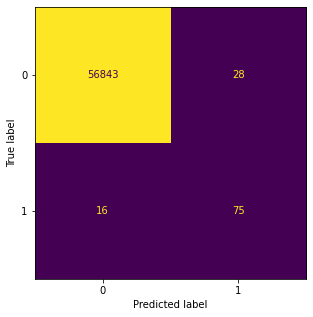

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

disp = ConfusionMatrixDisplay.from_predictions(y_teste, y_pred_boll, ax=ax,colorbar=False)

plt.show()

 auc score: 0.9911654697222034


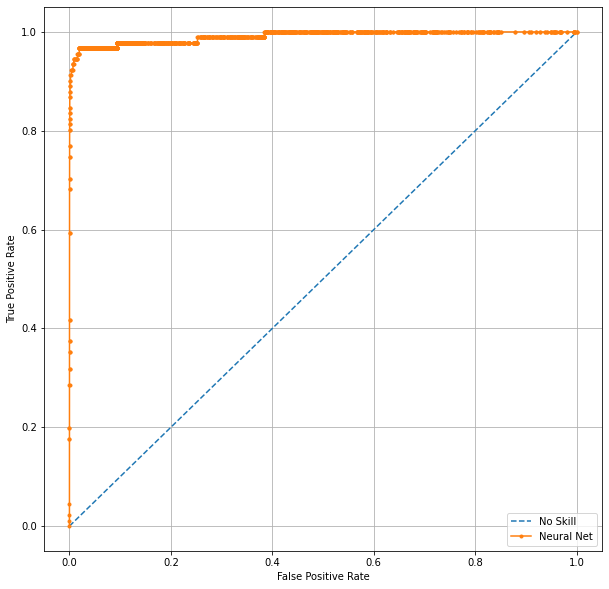

In [ ]:
fpr, tpr, thresholds = roc_curve(y_teste, y_pred)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Neural Net')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()

print(f' auc score: {roc_auc_score(y_teste, y_pred)}')

# bug report

https://github.com/keras-team/keras-tuner/issues/631